

Ответы на данное задание необходимо заполнить здесь - https://forms.gle/Ny8FmBtXVV4oQesP6

Само соревнование - https://www.kaggle.com/c/mai-ml-decision-trees/overview


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
1,1249,3,"Lockyer, Mr. Edward",male,NaN,0,0,1222,7.8792,NaN,S,0
2,1240,2,"Giles, Mr. Ralph",male,24.0,0,0,248726,13.5000,NaN,S,0
3,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,1
4,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,NaN,S,0


In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1167,2,"Bryhl, Miss. Dagmar Jenny Ingeborg",female,20.0,1,0,236853,26.00,NaN,S
1,1215,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.55,NaN,S
2,823,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.00,NaN,S
3,864,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
4,11,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.70,G6,S



## Извлечение признаков

Проделаем ту же самую работу, которая была в бейзлайне последнего соревнования


In [4]:
train_df["Title"] = train_df.Name.apply(lambda x: x.split(" ")[1].replace(".", ""))
test_df["Title"] = test_df.Name.apply(lambda x: x.split(" ")[1].replace(".", ""))

title_stat = train_df.groupby("Title").Name.agg(["count"])
title_stat["is_rare"] = title_stat["count"] < 10
titles = title_stat[~title_stat.is_rare].index.values

train_df.Title = train_df.Title.apply(lambda x: x if x in titles else "rare_title")
test_df.Title = test_df.Title.apply(lambda x: x if x in titles else "rare_title")

train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
0,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss
1,1249,3,"Lockyer, Mr. Edward",male,NaN,0,0,1222,7.8792,NaN,S,0,Mr
2,1240,2,"Giles, Mr. Ralph",male,24.0,0,0,248726,13.5000,NaN,S,0,Mr
3,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,1,Mr
4,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,NaN,S,0,Mrs


In [5]:
train_df.groupby("Title").PassengerId.count()

Title
Master         38
Miss          163
Mr            487
Mrs           123
rare_title     39
Name: PassengerId, dtype: int64

In [6]:
train_df["Children"] = train_df.Age.apply(lambda x: 1 if x < 18 else 0)
train_df["Mother"] = train_df.apply(lambda x: 1 if x.Sex == "female" and x.Age > 18 and x.Parch > 0 else 0, axis=1)
train_df["Family_size"] = train_df.SibSp + train_df.Parch + 1

test_df["Children"] = test_df.Age.apply(lambda x: 1 if x < 18 else 0)
test_df["Mother"] = test_df.apply(lambda x: 1 if x.Sex == "female" and x.Age > 18 and x.Parch > 0 else 0, axis=1)
test_df["Family_size"] = test_df.SibSp + test_df.Parch + 1

train_df["Deck"] = train_df.Cabin.astype("str").apply(lambda x: x[0] if x != "nan" else "no_deck")
test_df["Deck"] = test_df.Cabin.astype("str").apply(lambda x: x[0] if x != "nan" else "no_deck")

Заполним пропуски на этот раз медианными значениями

In [7]:
train_df.Age = train_df.Age.fillna(train_df.Age.dropna().median()).astype("int16")
train_df.Fare = train_df.Fare.fillna(train_df.Fare.dropna().median())
train_df.Embarked = train_df.Embarked.fillna("no_info")

test_df.Age = test_df.Age.fillna(train_df.Age.dropna().median()).astype("int16")
test_df.Fare = test_df.Fare.fillna(train_df.Fare.dropna().median())
test_df.Embarked = test_df.Embarked.fillna("no_info")

In [8]:
train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Children,Mother,Family_size,Deck
0,888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,1,Miss,0,0,1,B
1,1249,3,"Lockyer, Mr. Edward",male,28,0,0,1222,7.8792,NaN,S,0,Mr,0,0,1,no_deck
2,1240,2,"Giles, Mr. Ralph",male,24,0,0,248726,13.5000,NaN,S,0,Mr,0,0,1,no_deck
3,221,3,"Sunderland, Mr. Victor Francis",male,16,0,0,SOTON/OQ 392089,8.0500,NaN,S,1,Mr,1,0,1,no_deck
4,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60,1,0,24065,26.0000,NaN,S,0,Mrs,0,0,2,no_deck


In [9]:
train_df.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

## Базовая версия признаков

Для начала полностью повторим все шаги, которые были в бейзлайне и замерим качество

In [10]:
train_v1 = train_df.copy()
test_v1 = test_df.copy()

unnecessary_cols = ["Name", "Ticket", "SibSp", "Parch", "Cabin"]

train_v1 = train_v1.drop(unnecessary_cols, axis=1)
test_v1 = test_v1.drop(unnecessary_cols, axis=1)

encoder = LabelEncoder()
encoding_cols = ["Sex", "Embarked", "Title", "Deck"]

full_df = pd.concat([train_v1, test_v1], axis=0)

for col in encoding_cols:
    full_df[col] = encoder.fit_transform(full_df[col])
    
train_v1 = full_df[full_df.Survived.notnull()]
train_v1.Survived = train_v1.Survived.astype("int8")

test_v1 = full_df[full_df.Survived.isnull()]
test_v1.drop("Survived", axis=1, inplace=True)

feature_cols = [col for col in train_v1.columns if col not in {"PassengerId", "Survived"}]
target_col = "Survived"

X = train_v1[feature_cols].values
y = train_v1[target_col]
test_v1.head()

,Age,Children,Deck,Embarked,Family_size,Fare,Mother,PassengerId,Pclass,Sex,Title
0,20,0,8,2,2,26.00,0,1167,2,0,1
1,33,0,8,2,1,26.55,0,1215,1,1,2
2,38,0,8,2,1,0.00,0,823,1,1,4
3,28,0,8,2,11,69.55,0,864,3,0,1
4,4,1,6,2,3,16.70,0,11,3,0,1


In [11]:
train_v1.head()

,Age,Children,Deck,Embarked,Family_size,Fare,Mother,PassengerId,Pclass,Sex,Survived,Title
0,19,0,1,2,1,30.0000,0,888,1,0,1,1
1,28,0,8,2,1,7.8792,0,1249,3,1,0,2
2,24,0,8,2,1,13.5000,0,1240,2,1,0,2
3,16,1,8,2,1,8.0500,0,221,3,1,1,2
4,60,0,8,2,2,26.0000,0,1105,2,0,0,3


### 1. Дерево без настройки гиперпараметров

In [12]:
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42

model = DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [13]:
def make_submission(ids, preds, output_path='submission.csv'):
    subm = pd.DataFrame()
    subm['PassengerId'] = ids
    subm['Survived'] = preds
    subm.to_csv(output_path, index=False)

какой получается скор на public лидерборде в соревновании (c точностью до трех знаков)?

    0.760
    0.754
    0.759
    0.761

In [14]:
# Your code here
print(test_v1.columns)
X1 = test_v1[feature_cols].values
predict = model.predict(X1)
make_submission(test_df['PassengerId'].values, predict)
sub_1 = pd.read_csv('submission.csv')
print(0.754)

Index(['Age', 'Children', 'Deck', 'Embarked', 'Family_size', 'Fare', 'Mother',
       'PassengerId', 'Pclass', 'Sex', 'Title'],
      dtype='object')
0.754


Теперь ваша задача отрисовать дерево. Необходимые библиотеки указаны ниже, вам необходимо немного погуглить.

In [15]:
#!pip install pydotplus
#!pip install graphviz
import sklearn
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

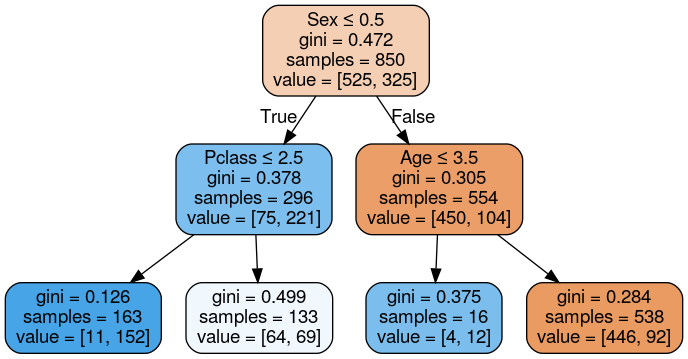

In [16]:
# Ваш код здесь
#dot_data = export_graphviz(model, feature_names=['Age', 'Children', 'Deck', 'Embarked', 'Family_size', 'Fare', 'Mother', 'Pclass', 'Sex', 'Title'])
#dot -Tpng 'tree.dot' -o 'tree.png'


#graph = pydotplus.graph_from_dot_data(dot_data)
#graph.write_png('tree.png')

#from IPython.core.display import Image, display
#display(Image('tree.png', unconfined=True))
dot_data = export_graphviz(model,
                                feature_names=['Age', 'Children', 'Deck', 'Embarked', 'Family_size', 'Fare', 'Mother', 'Pclass', 'Sex', 'Title'],
                                out_file=None,
                                filled=True,
                                rounded=True,
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  

from IPython.display import Image 
Image(graph.create_png()) 

сколько признаков задействуется в дереве с максимальной глубиной 2?

    2
    3
    4
    5

Ваш ответ ниже

In [17]:
print(3)

3


### 2. Дерево с настройкой гиперпараметров

In [18]:
from sklearn.model_selection import GridSearchCV

tree_params = {
    'max_depth': range(1, 8),
    'min_samples_leaf': range(1, 10)
}
tree_params = {'max_depth': list(range(1,8)),
'min_samples_leaf': list(range(1,10))}

# Your code here
tree = DecisionTreeClassifier()
GS = GridSearchCV(estimator=tree, param_grid=tree_params, cv=5)
print(GS)
GS.fit(X,y)
print(GS.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},


какие наилучшие параметры дает нам GridSearchCV

    max_depth=3, min_samples_leaf=6
    max_depth=4, min_samples_leaf=3
    max_depth=2, min_samples_leaf=7
    max_depth=3, min_samples_leaf=5

Ваш ответ ниже

In [19]:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
score = np.mean(cross_val_score(GS, X, y, cv=5, scoring="accuracy"))
print(score)

0.7788235294117647


какая средняя точность на 5 фолдах (с точностью до 3-х знаков)?

    0.797
    0.801
    0.794
    0.789

Ваш ответ ниже

In [26]:
print(GS.best_score_)

0.7941176470588235


**Теперь сделайте предсказания для тестовой выборки**

In [34]:
# Your code here
predict = GS.predict(X1)
make_submission(test_df['PassengerId'].values, predict)
sub_1 = pd.read_csv('submission.csv')
print(0.784)

0.784


какой получается public-score для данного предсказания?

    0.784
    0.782
    0.779
    0.791

### 3. One-hot Encoding

Теперь вспомним, что в нашем датасете есть категориальные признаки, которые попали в итоговые train и test выборки. Перед тем, как обучать дерево, мы воспользовались label encoding'-ом из sklearn. На выходе строки в таких колонках были преобразованы в соответствующие числа.

Как дерево будет работать с такими признаками?

Ответ - как с численными (<a href=https://github.com/scikit-learn/scikit-learn/issues/5442>пруф</a>)

Нас такой расклад не устраивает, потому что вместо того, чтобы делать сплит по каждому значению признака, дерево будет делать сплит только по тем значениям, при которых будет меняться значение таргета (см. доп. материалы по занятию, там этот момент освещен).

Поэтому чтобы дерево умело правильно работать с данными признаками, нам необходимо сделать one-hot encoding

Рассмотрим данное преобразование на конкретном примере:

Соответствие какому-то конкретному категориальному признаку выносится в отдельную бинарную колонку, как видно выше. И теперь по ходу процесса обучения алгоритм будет рассматривать данные колонки как категориальные, а не как вещественные.

In [20]:
unnecessary_cols = ["Name", "Ticket", "SibSp", "Parch", "Cabin"]

train_v2 = train_df.drop(unnecessary_cols, axis=1).copy()
test_v2 = test_df.drop(unnecessary_cols, axis=1).copy()

train_v2.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Title,Children,Mother,Family_size,Deck
0,888,1,female,19,30.0000,S,1,Miss,0,0,1,B
1,1249,3,male,28,7.8792,S,0,Mr,0,0,1,no_deck
2,1240,2,male,24,13.5000,S,0,Mr,0,0,1,no_deck
3,221,3,male,16,8.0500,S,1,Mr,1,0,1,no_deck
4,1105,2,female,60,26.0000,S,0,Mrs,0,0,2,no_deck


In [21]:
"""
train и test могут отличаться по значениям категориальных признаков.
Поэтому может получиться так, что train и test будут отличаться по
количеству и названию колонок после преобразования.
Чтобы этого избежать, объединим train и test, выполним OHE, а потом
разъединим обратно.
"""

categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Title', 'Mother', 'Deck']
full_df = pd.concat([train_v2, test_v2], axis=0)
dfs = []

for col in categorical_cols:
    print(f"Encoding {col}")
    df = pd.get_dummies(full_df[col], prefix=col)
    dfs.append(df)
    
full_df = pd.concat([full_df] + dfs, axis=1)
full_df = full_df.drop(categorical_cols, axis=1)

train_v2 = full_df[full_df.Survived.notnull()]
train_v2.Survived = train_v1.Survived.astype("int8")

test_v2 = full_df[full_df.Survived.isnull()]
test_v2 = test_v2.drop("Survived", axis=1)

Encoding Pclass
Encoding Sex
Encoding Embarked
Encoding Title
Encoding Mother
Encoding Deck


Убедимся, что train от test'a отличаются только тем, что в первом есть таргет, а во втором нет

In [22]:
set(train_v2.columns) - set(test_v2.columns)

{'Survived'}

In [23]:
feature_cols = [col for col in train_v2.columns if col not in {"PassengerId", "Survived"}]
target_col = "Survived"

X = train_v2[feature_cols].values
y = train_v2[target_col]

### Задание

Обучите дерево и подберите оптимальные гиперпараметры при помощи GridSearchCV на данной выборке

In [24]:
tree_params = {
    'max_depth': list(range(1, 10)),
    'min_samples_leaf': list(range(1, 10))
}

# Your code here
GS1 = GridSearchCV(estimator=tree, param_grid=tree_params, cv=5)
print(GS1)
GS1.fit(X, y)
print(GS1.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8,

какие наилучшие параметры дает нам GridSearchCV

    max_depth=3, min_samples_leaf=6
    max_depth=4, min_samples_leaf=3
    max_depth=2, min_samples_leaf=7
    max_depth=3, min_samples_leaf=9

Ваш ответ ниже

In [25]:
print(GS1.best_score_)
score = np.mean(cross_val_score(GS1, X, y, cv=5, scoring="accuracy"))
print(score)

0.8011764705882353
0.7623529411764707


какая средняя точность на 5 фолдах (с точностью до 3-х знаков)?

    0.797
    0.801
    0.794
    0.789

In [45]:
X2 = test_v2[feature_cols].values
predict = GS1.predict(X2)
make_submission(test_df['PassengerId'].values, predict)
sub_1 = pd.read_csv('submission.csv')

Получите предсказания и сделайте submit в соревнование

In [46]:
print(0.784)

0.784


какой public score дает данное дерево (с точностью до трех знаков)?

    0.794
    0.805
    0.791
    0.789

Ваш ответ ниже